## `GO_MWU` functional enrichment analysis

Here we will test for enrichment of GO categories in different groups of transcripts. The code is run by simply editing the names of the inputs and uncommenting certain lines of code as needed. See Mikhail Matz's [GitHub page](https://github.com/z0on/GO_MWU) on `GO_MWU` for more info. The code below is identical to the original script with the exception of some minor tweaks for plotting. 

All functional enrichment analyses in the report were carried out using the `GO_MWU_annot_1e-50.tsv` annotations file, which contains just matching GO terms from the arthropod eggNOG database with e-values at or below 1e-50. Putative contaminants identified by `EnTAP` are also discarded. See the `EnTAP2GO.py` script for more details about how to generate these GO term tables. Run from the `scripts/` directory with this line of code:

```
python EnTAP2GO.py ../EnTAP/entap_outfiles/final_results/final_annotations_lvl0.tsv ../GO_MWU/GO_MWU_annot_1e-50.tsv 1e-50 y Arthropoda
```

Also, before running this, you need to have already run the differential expression analysis in the `DESeq2_RhithroLoxo.ipynb` Jupyter notebook. This saves the required input files for `GO_MWU` into the `outputs/` folder. Copy all of these files (prefix GO_MWU) into the `GO_MWU` directory before proceeding. Also, run the following chunks of code to edit the annotations file so that transcripts that don't appear in the DESeq2 results (b/c flagged as contamination within the `DESeq2_RhithroLoxoDE` notebook) are excluded. This makes sure that all transcripts that don't appear in the expression matrix used in DESeq2 are removed from the annotations file.

First read in the annotations, the DESeq2 negative decimal log p-values, and the module kME values from WGCNA. Separate ones for the DESeq2 PvC and range comparisons because they used a different set of transcripts. Pick any WGCNA module input file because all of the transcript IDs are identical among them.

In [1]:
annot <- read.table("GO_MWU_annot_1e-50.tsv", sep="\t")
deseqIDs_PvC <- read.table("GO_MWU_PvC_pval.csv", sep=",", header = TRUE)
deseqIDs_range <- read.table("GO_MWU_interaction_pval.csv", sep=",", header = TRUE)
WGCNA_IDs <- read.table("GO_MWU_WGCNA_PvC_kMEyellow.csv", sep=",", header = TRUE)

Then let's just have a look to see that they are in the right format and of the correct dimensions.

In [2]:
head(annot)
head(deseqIDs_PvC)
head(deseqIDs_range)
head(WGCNA_IDs)

dim(annot)
dim(deseqIDs_PvC)
dim(deseqIDs_range)
dim(WGCNA_IDs)

V1,V2
TRINITY_DN127156_c0_g1_i1,GO:0006464;GO:0006508;GO:0008150;GO:0008152;GO:0009987;GO:0016567;GO:0019538;GO:0032446;GO:0036211;GO:0043170;GO:0043412;GO:0044237;GO:0044238;GO:0044260;GO:0044267;GO:0070647;GO:0071704;GO:0003674;GO:0003824;GO:0004842;GO:0016874;GO:0016879;GO:0016881;GO:0019787
TRINITY_DN127180_c0_g1_i1,GO:0007275;GO:0007399;GO:0008150;GO:0008152;GO:0009987;GO:0022008;GO:0030154;GO:0032501;GO:0032502;GO:0044699;GO:0044707;GO:0044763;GO:0048731;GO:0048856;GO:0048869;GO:0005575;GO:0003674;GO:0003824;GO:0016853
TRINITY_DN127142_c1_g1_i1,GO:0007154;GO:0007165;GO:0007166;GO:0007186;GO:0007218;GO:0008150;GO:0008152;GO:0009987;GO:0023052;GO:0044699;GO:0044700;GO:0044710;GO:0044763;GO:0050789;GO:0050794;GO:0050896;GO:0051716;GO:0055114;GO:0065007;GO:0005575;GO:0005623;GO:0005886;GO:0016020;GO:0016021;GO:0031224;GO:0044425;GO:0044464;GO:0071944;GO:0003674;GO:0003824;GO:0004871;GO:0004872;GO:0004888;GO:0004930;GO:0016491;GO:0038023;GO:0060089
TRINITY_DN127173_c0_g1_i1,GO:0006508;GO:0007154;GO:0007165;GO:0008150;GO:0008152;GO:0009987;GO:0019538;GO:0023052;GO:0035556;GO:0043170;GO:0044238;GO:0044699;GO:0044700;GO:0044763;GO:0050789;GO:0050794;GO:0050896;GO:0051716;GO:0065007;GO:0071704;GO:0003674;GO:0003824;GO:0008233;GO:0008237;GO:0016787;GO:0070011
TRINITY_DN127117_c0_g1_i1,GO:0007155;GO:0008150;GO:0009987;GO:0022610;GO:0044699;GO:0044763;GO:0005575;GO:0005576;GO:0005578;GO:0005604;GO:0031012;GO:0044420;GO:0044421
TRINITY_DN147313_c0_g1_i1,GO:0002165;GO:0007275;GO:0007444;GO:0007472;GO:0007476;GO:0007552;GO:0007560;GO:0008150;GO:0009653;GO:0009791;GO:0009886;GO:0009887;GO:0032501;GO:0032502;GO:0035107;GO:0035114;GO:0035120;GO:0035220;GO:0044699;GO:0044707;GO:0044767;GO:0048513;GO:0048563;GO:0048569;GO:0048707;GO:0048731;GO:0048736;GO:0048737;GO:0048856


name,pval
TRINITY_DN34991_c0_g1_i1,0.1191520
TRINITY_DN22619_c0_g1_i1,1.3186141
TRINITY_DN44279_c0_g1_i1,0.1388834
TRINITY_DN40042_c0_g1_i1,0.2827179
TRINITY_DN3373_c0_g1_i1,2.7114068
TRINITY_DN76095_c0_g1_i1,1.0108377


name,pval
TRINITY_DN34991_c0_g1_i1,0.2144906
TRINITY_DN22619_c0_g1_i1,0.2249192
TRINITY_DN44279_c0_g1_i1,1.8070926
TRINITY_DN40042_c0_g1_i1,1.1796284
TRINITY_DN3373_c0_g1_i1,0.2101009
TRINITY_DN76095_c0_g1_i1,0.6990298


transcript,kME
TRINITY_DN34991_c0_g1_i1,0
TRINITY_DN22619_c0_g1_i1,0
TRINITY_DN44279_c0_g1_i1,0
TRINITY_DN40042_c0_g1_i1,0
TRINITY_DN3373_c0_g1_i1,0
TRINITY_DN76095_c0_g1_i1,0


[1] 4948    2

[1] 60264     2

[1] 59485     2

[1] 60488     2

Looks good. The dimensions of the pvalue tables are slightly smaller than the expression matrices that went into DESeq2. That's because some of the transcripts were considered outliers and given p-values of NA, which were removed before exporting the results. The WGCNA modules will have more transcript IDs because it used the full expression matrix from the PvC DESeq2 analysis, without outliers removed.

Now I am going to identify the transcripts in the annotations table that do not appear in the pvalue tables, separately for the PvC comparison and the range comparison, as the expression matrices differed in transcript number after filtering (see `DESeq2_RhithroLoxo.ipynb`).

In [3]:
annot_PvC <- annot[annot[,1] %in% deseqIDs_PvC[,1],]
head(annot_PvC)
dim(annot_PvC)
annot_range <- annot[annot[,1] %in% deseqIDs_range[,1],]
head(annot_range)
dim(annot_range)
annot_WGCNA <- annot[annot[,1] %in% WGCNA_IDs[,1],]
head(annot_WGCNA)
dim(annot_WGCNA)

V1,V2
TRINITY_DN127156_c0_g1_i1,GO:0006464;GO:0006508;GO:0008150;GO:0008152;GO:0009987;GO:0016567;GO:0019538;GO:0032446;GO:0036211;GO:0043170;GO:0043412;GO:0044237;GO:0044238;GO:0044260;GO:0044267;GO:0070647;GO:0071704;GO:0003674;GO:0003824;GO:0004842;GO:0016874;GO:0016879;GO:0016881;GO:0019787
TRINITY_DN127180_c0_g1_i1,GO:0007275;GO:0007399;GO:0008150;GO:0008152;GO:0009987;GO:0022008;GO:0030154;GO:0032501;GO:0032502;GO:0044699;GO:0044707;GO:0044763;GO:0048731;GO:0048856;GO:0048869;GO:0005575;GO:0003674;GO:0003824;GO:0016853
TRINITY_DN127142_c1_g1_i1,GO:0007154;GO:0007165;GO:0007166;GO:0007186;GO:0007218;GO:0008150;GO:0008152;GO:0009987;GO:0023052;GO:0044699;GO:0044700;GO:0044710;GO:0044763;GO:0050789;GO:0050794;GO:0050896;GO:0051716;GO:0055114;GO:0065007;GO:0005575;GO:0005623;GO:0005886;GO:0016020;GO:0016021;GO:0031224;GO:0044425;GO:0044464;GO:0071944;GO:0003674;GO:0003824;GO:0004871;GO:0004872;GO:0004888;GO:0004930;GO:0016491;GO:0038023;GO:0060089
TRINITY_DN127173_c0_g1_i1,GO:0006508;GO:0007154;GO:0007165;GO:0008150;GO:0008152;GO:0009987;GO:0019538;GO:0023052;GO:0035556;GO:0043170;GO:0044238;GO:0044699;GO:0044700;GO:0044763;GO:0050789;GO:0050794;GO:0050896;GO:0051716;GO:0065007;GO:0071704;GO:0003674;GO:0003824;GO:0008233;GO:0008237;GO:0016787;GO:0070011
TRINITY_DN127117_c0_g1_i1,GO:0007155;GO:0008150;GO:0009987;GO:0022610;GO:0044699;GO:0044763;GO:0005575;GO:0005576;GO:0005578;GO:0005604;GO:0031012;GO:0044420;GO:0044421
TRINITY_DN147313_c0_g1_i1,GO:0002165;GO:0007275;GO:0007444;GO:0007472;GO:0007476;GO:0007552;GO:0007560;GO:0008150;GO:0009653;GO:0009791;GO:0009886;GO:0009887;GO:0032501;GO:0032502;GO:0035107;GO:0035114;GO:0035120;GO:0035220;GO:0044699;GO:0044707;GO:0044767;GO:0048513;GO:0048563;GO:0048569;GO:0048707;GO:0048731;GO:0048736;GO:0048737;GO:0048856


[1] 4283    2

V1,V2
TRINITY_DN127156_c0_g1_i1,GO:0006464;GO:0006508;GO:0008150;GO:0008152;GO:0009987;GO:0016567;GO:0019538;GO:0032446;GO:0036211;GO:0043170;GO:0043412;GO:0044237;GO:0044238;GO:0044260;GO:0044267;GO:0070647;GO:0071704;GO:0003674;GO:0003824;GO:0004842;GO:0016874;GO:0016879;GO:0016881;GO:0019787
TRINITY_DN127180_c0_g1_i1,GO:0007275;GO:0007399;GO:0008150;GO:0008152;GO:0009987;GO:0022008;GO:0030154;GO:0032501;GO:0032502;GO:0044699;GO:0044707;GO:0044763;GO:0048731;GO:0048856;GO:0048869;GO:0005575;GO:0003674;GO:0003824;GO:0016853
TRINITY_DN127142_c1_g1_i1,GO:0007154;GO:0007165;GO:0007166;GO:0007186;GO:0007218;GO:0008150;GO:0008152;GO:0009987;GO:0023052;GO:0044699;GO:0044700;GO:0044710;GO:0044763;GO:0050789;GO:0050794;GO:0050896;GO:0051716;GO:0055114;GO:0065007;GO:0005575;GO:0005623;GO:0005886;GO:0016020;GO:0016021;GO:0031224;GO:0044425;GO:0044464;GO:0071944;GO:0003674;GO:0003824;GO:0004871;GO:0004872;GO:0004888;GO:0004930;GO:0016491;GO:0038023;GO:0060089
TRINITY_DN127173_c0_g1_i1,GO:0006508;GO:0007154;GO:0007165;GO:0008150;GO:0008152;GO:0009987;GO:0019538;GO:0023052;GO:0035556;GO:0043170;GO:0044238;GO:0044699;GO:0044700;GO:0044763;GO:0050789;GO:0050794;GO:0050896;GO:0051716;GO:0065007;GO:0071704;GO:0003674;GO:0003824;GO:0008233;GO:0008237;GO:0016787;GO:0070011
TRINITY_DN127117_c0_g1_i1,GO:0007155;GO:0008150;GO:0009987;GO:0022610;GO:0044699;GO:0044763;GO:0005575;GO:0005576;GO:0005578;GO:0005604;GO:0031012;GO:0044420;GO:0044421
TRINITY_DN147313_c0_g1_i1,GO:0002165;GO:0007275;GO:0007444;GO:0007472;GO:0007476;GO:0007552;GO:0007560;GO:0008150;GO:0009653;GO:0009791;GO:0009886;GO:0009887;GO:0032501;GO:0032502;GO:0035107;GO:0035114;GO:0035120;GO:0035220;GO:0044699;GO:0044707;GO:0044767;GO:0048513;GO:0048563;GO:0048569;GO:0048707;GO:0048731;GO:0048736;GO:0048737;GO:0048856


[1] 4278    2

V1,V2
TRINITY_DN127156_c0_g1_i1,GO:0006464;GO:0006508;GO:0008150;GO:0008152;GO:0009987;GO:0016567;GO:0019538;GO:0032446;GO:0036211;GO:0043170;GO:0043412;GO:0044237;GO:0044238;GO:0044260;GO:0044267;GO:0070647;GO:0071704;GO:0003674;GO:0003824;GO:0004842;GO:0016874;GO:0016879;GO:0016881;GO:0019787
TRINITY_DN127180_c0_g1_i1,GO:0007275;GO:0007399;GO:0008150;GO:0008152;GO:0009987;GO:0022008;GO:0030154;GO:0032501;GO:0032502;GO:0044699;GO:0044707;GO:0044763;GO:0048731;GO:0048856;GO:0048869;GO:0005575;GO:0003674;GO:0003824;GO:0016853
TRINITY_DN127142_c1_g1_i1,GO:0007154;GO:0007165;GO:0007166;GO:0007186;GO:0007218;GO:0008150;GO:0008152;GO:0009987;GO:0023052;GO:0044699;GO:0044700;GO:0044710;GO:0044763;GO:0050789;GO:0050794;GO:0050896;GO:0051716;GO:0055114;GO:0065007;GO:0005575;GO:0005623;GO:0005886;GO:0016020;GO:0016021;GO:0031224;GO:0044425;GO:0044464;GO:0071944;GO:0003674;GO:0003824;GO:0004871;GO:0004872;GO:0004888;GO:0004930;GO:0016491;GO:0038023;GO:0060089
TRINITY_DN127173_c0_g1_i1,GO:0006508;GO:0007154;GO:0007165;GO:0008150;GO:0008152;GO:0009987;GO:0019538;GO:0023052;GO:0035556;GO:0043170;GO:0044238;GO:0044699;GO:0044700;GO:0044763;GO:0050789;GO:0050794;GO:0050896;GO:0051716;GO:0065007;GO:0071704;GO:0003674;GO:0003824;GO:0008233;GO:0008237;GO:0016787;GO:0070011
TRINITY_DN127117_c0_g1_i1,GO:0007155;GO:0008150;GO:0009987;GO:0022610;GO:0044699;GO:0044763;GO:0005575;GO:0005576;GO:0005578;GO:0005604;GO:0031012;GO:0044420;GO:0044421
TRINITY_DN147313_c0_g1_i1,GO:0002165;GO:0007275;GO:0007444;GO:0007472;GO:0007476;GO:0007552;GO:0007560;GO:0008150;GO:0009653;GO:0009791;GO:0009886;GO:0009887;GO:0032501;GO:0032502;GO:0035107;GO:0035114;GO:0035120;GO:0035220;GO:0044699;GO:0044707;GO:0044767;GO:0048513;GO:0048563;GO:0048569;GO:0048707;GO:0048731;GO:0048736;GO:0048737;GO:0048856


[1] 4293    2

Okay so we went from 4948 transcripts with annotations to 4283, 4278, and 4293 when looking at just those included in DESeq2 PvC, DESeq2 range, and WGCNA, respectively. It's important that the transcripts in the annotations file correspond to those in the results file "since the test relies on comparing the behavior of individual GO categories to the whole." (From GO_MWU GitHub).

Now I'll save these tables to file so they can be read in by the GO_MWU functions.

In [4]:
write.table(annot_PvC, file="GO_MWU_annot_1e-50_PvC.tsv", sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)
write.table(annot_range, file="GO_MWU_annot_1e-50_range.tsv", sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)
write.table(annot_WGCNA, file="GO_MWU_annot_1e-50_WGCNA.tsv", sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

Rather than repeat all of the following lines of code for the various tests and datasets, just use the files specified below as `input` and re-run, changing the filepath for saving output images. Make sure to switch among GO divisions, including in output filepath as well, so there are three plots each. Also, make sure to use the appropriate annotations file, depending on if you are looking at PvC, range, or WGCNA, as they do not contain the identical transcripts. 

There are many possible enrichment analyses one can run given the output from the `DESeq2_RhithroLoxo.ipynb` and `WGCNA_PvC.ipynb`. I am going to focus just on the following:

>Infected vs. control DESeq2 pvalues, Mann-Whitney U test:
>>`GO_MWU_PvC_pval.csv`

>Infected vs. control DESeq2, Fisher's exact test:
>>`GO_MWU_PvC_fisher.csv`

>Range:condition interaction DESeq2 pvalues, Mann-Whitney U test:
>>`GO_MWU_interaction_pval.csv` (Use one-tailed test. For explanation, see `DESeq2_RhithroLoxo.ipynb`)

>Range:condition interaction, range pair contrasts, DESeq2 pvalues, Mann-Whitney U test:
>>`GO_MWU_interaction_AvI_pval.csv` (absent vs invasive)

>>`GO_MWU_interaction_AvN_pval.csv` (absent vs native)

>>`GO_MWU_interaction_IvN_pval.csv` (invasive vs native)

>WGCNA_PvC modules (infection and infection:sex):

>>`GO_MWU_WGCNA_PvC_kMEcyan.csv`

>>`GO_MWU_WGCNA_PvC_kMElightcyan.csv`

>>`GO_MWU_WGCNA_PvC_kMEsalmon.csv` This is the one that showed interesting interaction between infection and sex

Note that `GO_MWU` may return a message about "terms without a defined level." Apparently `EnTAP` is returning some deprecated GO terms, as was also noted [here](https://github.com/fishercera/TreehopperSeq/blob/master/GoSeq_Walkthrough.md).

In [57]:
input="GO_MWU_interaction_AvI_pval.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="GO_MWU_annot_1e-50_range.tsv" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="CC" # either MF, or BP, or CC
source("gomwu.functions.R")

Below, remember to comment/uncomment depending on if analyzing WGCNA module or not. We are using signed modules. Also uncomment the "Alternative='g'" line for the `GO_MWU_interaction_pval` test.

In [58]:
gomwuStats(input, goDatabase, goAnnotations, goDivision,
	perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
	largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
	smallest=5,   # a GO category should contain at least this many genes to be considered
	clusterCutHeight=0.25, # threshold for merging similar (gene-sharing) terms. See README for details.
	#Alternative="g" # by default the MWU test is two-tailed; specify "g" or "l" of you want to test for "greater" or "less" instead. 
	#Module=TRUE,Alternative="g" # un-remark this if you are analyzing a SIGNED WGCNA module (values: 0 for not in module genes, kME for in-module genes). In the call to gomwuPlot below, specify absValue=0.001 (count number of "good genes" that fall into the module)
	#Module=TRUE # un-remark this if you are analyzing an UNSIGNED WGCNA module 
)

Continuous measure of interest: will perform MWU test


98 GO terms at 10% FDR


Also, below you can adjust the pval levels to determine which GO terms under which thresholds to plot. They need to be adjusted depending on the number of significant GO terms because otherwise there will be too many/too few to display. See output images for thresholds if you are interested in replicating figures from the paper. Also, be sure to change the absValue threshold for "good genes" depending on type of analysis you are doing (-log pvalues, LFCs, Fisher, WGCNA modules, etc.) See package instructions. Remember to change the name of the output file and to change settings in both code chunks (one for saving, one for displaying).

Warning message in plot.formula(c(1:top) ~ c(1:top), type = "n", axes = F, xlab = "", :
“the formula 'c(1:top) ~ c(1:top)' is treated as 'c(1:top) ~ 1'”Warning message in plot.formula(c(1:top) ~ c(1:top), type = "n", axes = F, xlab = "", :
“the formula 'c(1:top) ~ c(1:top)' is treated as 'c(1:top) ~ 1'”GO terms dispayed: 82
"Good genes" accounted for:  470 out of 489 ( 96% )


png 
  2

Warning message in plot.formula(c(1:top) ~ c(1:top), type = "n", axes = F, xlab = "", :
“the formula 'c(1:top) ~ c(1:top)' is treated as 'c(1:top) ~ 1'”Warning message in plot.formula(c(1:top) ~ c(1:top), type = "n", axes = F, xlab = "", :
“the formula 'c(1:top) ~ c(1:top)' is treated as 'c(1:top) ~ 1'”GO terms dispayed: 82
"Good genes" accounted for:  470 out of 489 ( 96% )


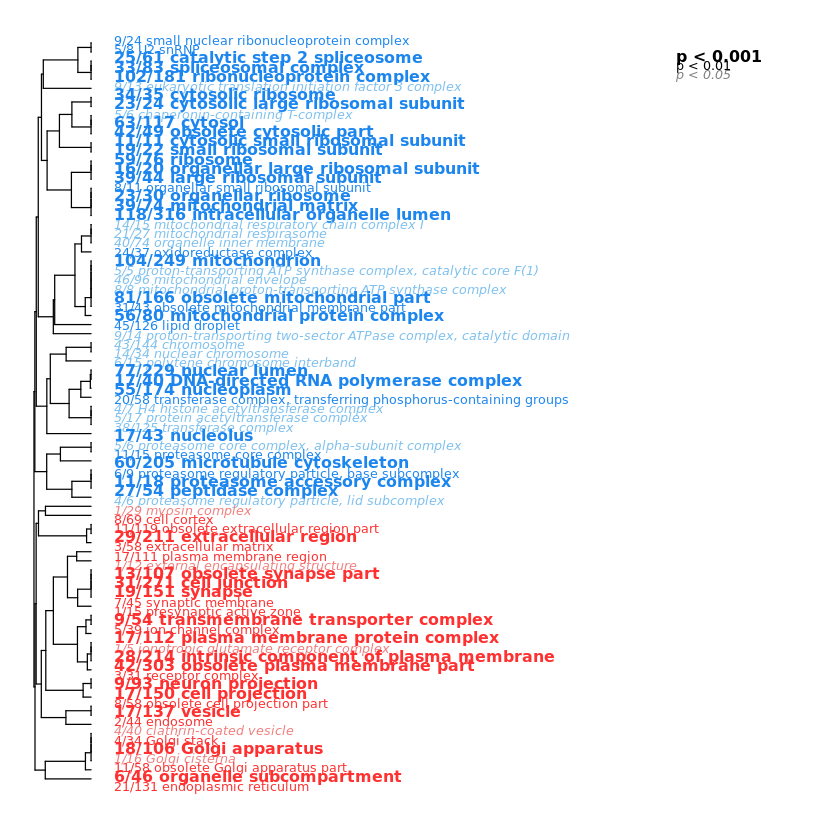

In [59]:
#save plot
pdf("../vis/GO_MWU_interaction_AvI_pval_annot_1e-50_CC.pdf")#, pointsize=60, height=2200, width=2500)
results=gomwuPlot(input,goAnnotations,goDivision,
	absValue=-log(0.05,10),  # genes with the measure value exceeding this will be counted as "good genes". This setting is for signed log-pvalues. Specify absValue=0.001 if you are doing Fisher's exact test for standard GO enrichment or analyzing a WGCNA module (all non-zero genes = "good genes").
    #absValue=0.001, #if doing Fisher, WGCNA module, or are using log2-fold changes
	level1=0.05, # FDR threshold for plotting. Specify level1=1 to plot all GO categories containing genes exceeding the absValue.
	level2=0.01, # FDR cutoff to print in regular (not italic) font.
	level3=0.001, # FDR cutoff to print in large bold font.
	txtsize=1.2,    # decrease to fit more on one page, or increase (after rescaling the plot so the tree fits the text) for better "word cloud" effect
	treeHeight=0.5, # height of the hierarchical clustering tree
	#colors=c("gray0","gray0","gray57","gray57") # these are default colors, un-remar and change if needed
)
dev.off()

#show plot
results=gomwuPlot(input,goAnnotations,goDivision,
    absValue=-log(0.05,10),  # genes with the measure value exceeding this will be counted as "good genes". This setting is for signed log-pvalues. Specify absValue=0.001 if you are doing Fisher's exact test for standard GO enrichment or analyzing a WGCNA module (all non-zero genes = "good genes").
    #absValue=0.001, #if doing Fisher, WGCNA module, or are using log2-fold changes
	level1=0.05, # FDR threshold for plotting. Specify level1=1 to plot all GO categories containing genes exceeding the absValue.
	level2=0.01, # FDR cutoff to print in regular (not italic) font.
	level3=0.001, # FDR cutoff to print in large bold font.
	txtsize=1.2,    # decrease to fit more on one page, or increase (after rescaling the plot so the tree fits the text) for better "word cloud" effect
	treeHeight=0.5, # height of the hierarchical clustering tree
	#colors=c("gray0","gray0","gray57","gray57") # these are default colors, un-remar and change if needed
)
